In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import keras 
import tensorflow as tf
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

from PIL import Image
from skimage.io import imread, imshow, imsave
from pathlib import Path
from tensorflow.keras.preprocessing import image #для загрузки картинки
import cv2

In [32]:
#Загружаем картинки из датасета

path_imgs_train = "C:/Users/Владелец/Downloads/CamVid/train"
path_imgs_tr_lab = "C:/Users/Владелец/Downloads/CamVid/train_labels"

path_imgs_test = "C:/Users/Владелец/Downloads/CamVid/test"
path_imgs_test_lab = "C:/Users/Владелец/Downloads/CamVid/test_labels"

img_train_path = list(Path(path_imgs_train).iterdir())
img_train_lab_path = list(Path(path_imgs_tr_lab).iterdir())

img_test_path = list(Path(path_imgs_test).iterdir())
img_test_lab_path = list(Path(path_imgs_test_lab).iterdir())

In [33]:
img = imread("C:/Users/Владелец/Downloads/CamVid/train/0001TP_009210.png")

In [34]:
img.shape

(720, 960, 3)

In [35]:
images_train = list()
labels_train = list()

images_test = list()
labels_test = list()


for tr, tr_lab in zip(img_train_path, img_train_lab_path):
    images_train.append(image.load_img(tr, target_size = (128, 192)))
    labels_train.append(image.load_img(tr_lab, target_size = (128, 192)))
 
    

for test, test_lab in zip(img_test_path, img_test_lab_path):
    images_test.append(image.load_img(test, target_size = (128, 192)))
    labels_test.append(image.load_img(test_lab, target_size = (128, 192)))

#Помещаем выборки и маски в списки

In [36]:
len(images_train), len(images_test)

#369 изображений и масок в трейне и 232 в тесте

(369, 232)

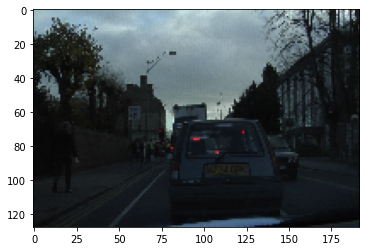

In [37]:
plt.imshow(images_train[0])
plt.show()
#Картинка

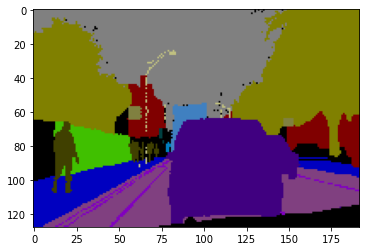

In [38]:
plt.imshow(labels_train[0])
plt.show()
#Маска

In [39]:
#Переведем картинки в последовательность 

x_train = list()

for img in images_train:
    x = image.img_to_array(img)
    x_train.append(x)

x_train = np.array(x_train) #переводим в массив

In [40]:
x_train.shape
#369 картинок 128 на 192 и 3 фильтра (RGB)

(369, 128, 192, 3)

In [41]:
x_test = list()

for img in images_test:
    x = image.img_to_array(img)
    x_test.append(x)

x_test = np.array(x_test)

In [42]:
x_test.shape
#232 изображения 128 на 192 и 3 фильтра

(232, 128, 192, 3)

In [43]:
classes = pd.read_csv("C:/Users/Владелец/Downloads/CamVid/class_dict.csv", encoding = "utf-8")

classes
#Разметка - смотрим цвет воспринимает диапазона для сегм. картинки
#Насколько сам понял - цвет маски опрделенного объекта на картинки (как машина - смесь оттенка красного и синего)

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [44]:
rgb_col = []

for r, g, b in zip(classes["r"], classes["g"], classes["b"]):
    rgb_col.append([r, g, b])

#Считываем данные для будущей разметки из пандас в массив

In [45]:
rgb_col

[[64, 128, 64],
 [192, 0, 128],
 [0, 128, 192],
 [0, 128, 64],
 [128, 0, 0],
 [64, 0, 128],
 [64, 0, 192],
 [192, 128, 64],
 [192, 192, 128],
 [64, 64, 128],
 [128, 0, 192],
 [192, 0, 64],
 [128, 128, 64],
 [192, 0, 192],
 [128, 64, 64],
 [64, 192, 128],
 [64, 64, 0],
 [128, 64, 128],
 [128, 128, 192],
 [0, 0, 192],
 [192, 128, 128],
 [128, 128, 128],
 [64, 128, 192],
 [0, 0, 64],
 [0, 64, 64],
 [192, 64, 128],
 [128, 128, 0],
 [192, 128, 192],
 [64, 0, 64],
 [192, 192, 0],
 [0, 0, 0],
 [64, 192, 0]]

In [46]:
def col_to_index(y, cols = rgb_col):
    y_ind = np.zeros((y.shape[0], y.shape[1]))# Создаем пустой массив
    y_cat = np.zeros((y.shape[0], y.shape[1], len(cols)))
    i = 1
    for i_color in cols:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind


#Делаем one-hot encoding для выходных параметров

In [47]:
cat_y, ind_y = col_to_index(image.img_to_array(labels_train[0]))

In [48]:
cat_y

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

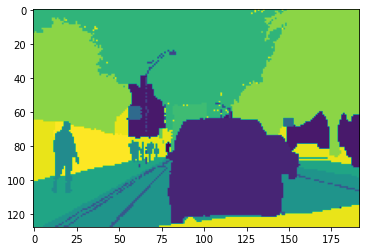

In [49]:
plt.imshow(ind_y)
plt.show()

In [50]:
ind_y

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

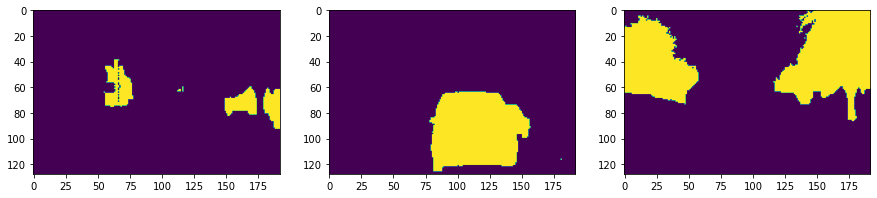

In [51]:
fig, ax = plt.subplots(1, 3, figsize = (15, 15))

ax[0].imshow(cat_y[..., 4])
ax[1].imshow(cat_y[..., 5])
ax[2].imshow(cat_y[..., 26])
plt.show()
# Смотрим на размеченные данные - на первой выделяются здания, на второй машины, на третьей деревья. 

In [52]:
cat_y.shape

#128 на 192 и 32 фильтра

(128, 192, 32)

In [53]:
#Делаем разметку на 32 классо

y = list()

for mask in labels_train:
    y_cat, _ = col_to_index(image.img_to_array(mask))
    y.append(y_cat)

y = np.array(y)

In [54]:
y.shape

(369, 128, 192, 32)

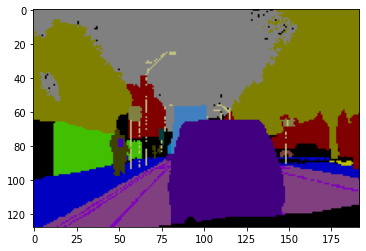

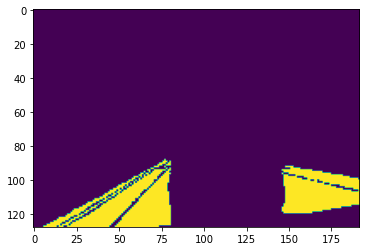

In [55]:
# Смотрим на сегментацию на картинке 2 по классу 17 - дороге. 
plt.imshow(labels_train[2].convert('RGBA'))
plt.show()
img = y[2][..., 17]

plt.imshow(img)
plt.show()

In [56]:
x_train.shape

(369, 128, 192, 3)

In [61]:
y.shape

(369, 128, 192, 32)

In [57]:
y_test = list()

for mask in labels_test:
    y_cat, _ = col_to_index(image.img_to_array(mask))
    y_test.append(y_cat)

y_test = np.array(y_test)

In [58]:
y_test.shape

(232, 128, 192, 32)

In [59]:
x_test.shape

(232, 128, 192, 3)

In [62]:
import keras.backend as K


def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

#Создадим метрику dice - площадь пересечения дважды, деленная на общее количество пикселей на двух картинках. 
#Чем ближе к 1, тем лучше показатель

# Создаем модель


In [68]:
from keras.layers import Activation, Input, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, concatenate

from tensorflow.keras.utils import plot_model 

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

In [75]:
#Сделаем модель U-net

def Unet(num_classes=32, input_shape=(128, 192, 3)):
    img_input = Input(input_shape)

    # Первая свертка
    x = Conv2D(70, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(70, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Вторая свертка 
    x = Conv2D(140, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(140, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)


    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # 3 свертка
    x = Conv2D(280, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(280, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(280, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)


    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # 4 свертка
    x = Conv2D(560, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(560, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(560, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    block_4_out = Activation('relu')(x)

 
    # Начинаем декодирование. Увеличиваем картинку
    x = Conv2DTranspose(280, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(280, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(280, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 2 этап
    x = Conv2DTranspose(140, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(140, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(140, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3 этап
    x = Conv2DTranspose(70, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(70, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(70, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Классификация
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [76]:
model = Unet(32, (128, 192, 3))

#32 фильтра и размерность

In [77]:
model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])

#Компелируем модель, метрика - dice, лосс - категориальная кросс-энтроп т.к. множественная классификация 

In [78]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 192, 70  1960        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_57 (BatchN  (None, 128, 192, 70  280        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

 batch_normalization_66 (BatchN  (None, 16, 24, 560)  2240       ['block4_conv3[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_9 (Conv2DTran  (None, 32, 48, 280)  627480     ['batch_normalization_66[0][0]'] 
 spose)                                                                                           
                                                                                                  
 batch_normalization_67 (BatchN  (None, 32, 48, 280)  1120       ['conv2d_transpose_9[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_67 (Activation)     (None, 32, 48, 280)  0           ['batch_normalization_67[0][0]'] 
          

 conv2d_27 (Conv2D)             (None, 128, 192, 32  20192       ['activation_75[0][0]']          
                                )                                                                 
                                                                                                  
Total params: 12,774,332
Trainable params: 12,765,512
Non-trainable params: 8,820
__________________________________________________________________________________________________


In [80]:
model_1 = model.fit(x_train, y,
                      epochs=4,
                      batch_size=1,
                      validation_data=(x_test, y_test))

Epoch 1/4
369/369 [==============================] - 645s 2s/step - loss: 1.0365 - dice_coef: 0.5789 - val_loss: 2.3272 - val_dice_coef: 0.3307
Epoch 2/4
369/369 [==============================] - 423s 1s/step - loss: 0.8453 - dice_coef: 0.6489 - val_loss: 1.4977 - val_dice_coef: 0.5286
Epoch 3/4
369/369 [==============================] - 415s 1s/step - loss: 0.7496 - dice_coef: 0.6833 - val_loss: 1.6536 - val_dice_coef: 0.3970
Epoch 4/4
369/369 [==============================] - 413s 1s/step - loss: 0.6857 - dice_coef: 0.7085 - val_loss: 1.1504 - val_dice_coef: 0.5694


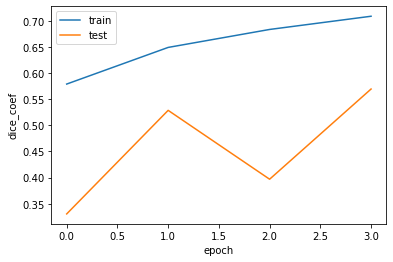

In [81]:
plt.plot(model_1.history['dice_coef'], label='train')
plt.plot(model_1.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Модель показала неплохой результат - за четыре эпохи лосс снизился почти наполовину а dice поднялся с 0.3 до почти 0.6
#Модель имеет тенденцию к росту качества, если увеличить количество эпох. 
#На 15-25 эпохах качество наверняка будет высоким
#Минус - очень долго обучается. Из-за длинного ожидания по времени не получается хорошо проанализировать и поиграть с количеством слоев и фильтров


In [84]:
pred = model.predict(x_test)

8/8 [==============================] - 50s 6s/step


In [85]:
pred.shape

(232, 128, 192, 32)